# Prepare resources

In [1]:
# download list of TFs
!wget -O ../scenic_resource/hs_hgnc_curated_tfs.txt https://raw.githubusercontent.com/aertslab/pySCENIC/master/resources/hs_hgnc_curated_tfs.txt
!wget -O ../scenic_resource/hs_hgnc_tfs.txt https://raw.githubusercontent.com/aertslab/pySCENIC/master/resources/hs_hgnc_tfs.txt
!wget -O ../scenic_resource/lambert2018.txt https://raw.githubusercontent.com/aertslab/pySCENIC/master/resources/lambert2018.txt

--2024-06-07 09:36:13--  https://raw.githubusercontent.com/aertslab/pySCENIC/master/resources/hs_hgnc_curated_tfs.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8585 (8.4K) [text/plain]
Saving to: ‘../scenic_resource/hs_hgnc_curated_tfs.txt’

../scenic_resource/ 100%[===================>]   8.38K  --.-KB/s    in 0s      

2024-06-07 09:36:14 (133 MB/s) - ‘../scenic_resource/hs_hgnc_curated_tfs.txt’ saved [8585/8585]

--2024-06-07 09:36:14--  https://raw.githubusercontent.com/aertslab/pySCENIC/master/resources/hs_hgnc_tfs.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP re

In [2]:
def read_tf_file(filename):
    with open(filename, 'r') as tf_file:
        tfs = set(line.rstrip() for line in tf_file)
    
    return tfs


hgnc_tfs = read_tf_file('../scenic_resource/hs_hgnc_tfs.txt')
lambert_tfs = read_tf_file('../scenic_resource/lambert2018.txt')
hgnc_tfs_curated = read_tf_file('../scenic_resource/hs_hgnc_curated_tfs.txt')

(hgnc_tfs & lambert_tfs) == hgnc_tfs_curated

True

since they already provide the curated list we actually don't need to do all the things described [here](https://github.com/aertslab/pySCENIC/blob/master/notebooks/pySCENIC%20-%20List%20of%20Transcription%20Factors.ipynb). However, the [Nature protocol](https://www.nature.com/articles/s41596-020-0336-2) suggest using the full list found in `hgnc_tfs.txt` so we just follow this one and us it.

In [5]:
# download cistrarget databases
!wget -O ../scenic_resource/motifs-v9-nr.hgnc-m0.001-o0.0.tbl https://resources.aertslab.org/cistarget/motif2tf/motifs-v9-nr.hgnc-m0.001-o0.0.tbl
!wget -O ../scenic_resource/hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings.feather https://resources.aertslab.org/cistarget/databases/homo_sapiens/hg38/refseq_r80/mc9nr/gene_based/hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings.feather

--2024-06-07 09:56:35--  https://resources.aertslab.org/cistarget/motif2tf/motifs-v9-nr.hgnc-m0.001-o0.0.tbl
Resolving resources.aertslab.org (resources.aertslab.org)... 134.58.50.9
Connecting to resources.aertslab.org (resources.aertslab.org)|134.58.50.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 103568514 (99M)
Saving to: ‘../scenic_resource/motifs-v9-nr.hgnc-m0.001-o0.0.tbl.html’

../scenic_resource/ 100%[===================>]  98.77M  61.7MB/s    in 1.6s    

2024-06-07 09:56:37 (61.7 MB/s) - ‘../scenic_resource/motifs-v9-nr.hgnc-m0.001-o0.0.tbl.html’ saved [103568514/103568514]

--2024-06-07 09:56:37--  https://resources.aertslab.org/cistarget/databases/homo_sapiens/hg38/refseq_r80/mc9nr/gene_based/hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings.feather
Resolving resources.aertslab.org (resources.aertslab.org)... 134.58.50.9
Connecting to resources.aertslab.org (resources.aertslab.org)|134.58.50.9|:443... connected.
HTTP request

# Run SCENIC
This follows the description of the full pipeline [here](https://github.com/aertslab/pySCENIC/blob/master/notebooks/pySCENIC%20-%20Full%20pipeline.ipynb). Beware that you may need to install pyscenic and aboreto from their git source. By the time of writing this there was one bug in either of their PyPI distributions that were fixed in the git sources but not propagated to PyPI due to them not bumping the package versions.

In [1]:
import anndata as ad

from arboreto.utils import load_tf_names
from arboreto.algo import grnboost2

from ctxcore.rnkdb import FeatherRankingDatabase as RankingDatabase
from pyscenic.utils import modules_from_adjacencies
from pyscenic.prune import prune2df, df2regulons
from pyscenic.aucell import aucell

In [2]:
adata = ad.read_h5ad('../data/tregs.tissue.scps.scvi.h5ad')
adata.X = adata.layers['counts'].copy()
adata

AnnData object with n_obs × n_vars = 9773 × 20912
    obs: 'sample_id', 'patient_id', 'status', 'tissue', 'cell_fraction', 'doublet', 'doublet_score', 'nFeature_RNA', 'nCount_RNA', 'percent_mt', 'percent_ribo', 'qc_pass', '_scvi_batch', '_scvi_labels', 'leiden_scvi_0.1', 'coarse_cell_types', 'leiden_scvi_0.4', 'dataset'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'neighbors', 'umap'
    obsm: 'X_scvi', 'X_umap'
    layers: 'counts', 'scvi_normalized'
    obsp: 'connectivities', 'distances'

In [6]:
import numpy as np

percent_expressed = np.array((adata.X > 0).sum(axis = 0) / adata.n_obs)[0, :]

In [7]:
thresholds = [0.05, 0.01, 0.005, 0.001]
data = {
    f'raw_p{p}': adata[:, percent_expressed > p].copy()
    for p
    in thresholds
}

In [8]:
import pandas as pd

for p in thresholds:
    df = pd.read_csv(
        f'../scenic_resource/recombat_p{p}.tsv',
        sep = '\t',
        index_col = 0
    )
    bdata = ad.AnnData(
        X = df.values,
        obs = adata.obs.loc[df.index, :],
        var = adata.var.loc[df.columns, :]
    )
    data[f'recombat_p{p}'] = bdata

In [5]:
import numpy as np

data = {}
thresholds = [0.05, 0.01, 0.005, 0.001]
diseases = adata[adata.obs.status != 'normal', :].copy()
percent_expressed_diseases = np.array((diseases.X > 0).sum(axis = 0) / diseases.n_obs)[0, :]

for p in thresholds:
    data[f'raw_disease_p{p}'] = diseases[:, percent_expressed_diseases > p].copy()

In [7]:
import pandas as pd

for p in thresholds:
    df = pd.read_csv(
        f'../scenic_resource/recombat_disease_only_p{p}.tsv',
        sep = '\t',
        index_col = 0
    )
    bdata = ad.AnnData(
        X = df.values,
        obs = adata.obs.loc[df.index, :],
        var = adata.var.loc[df.columns, :]
    )
    data[f'recombat_disease_p{p}'] = bdata

In [8]:
# load databases
with open('../scenic_resource/hs_hgnc_tfs.txt', 'r') as tf_file:
    tf_names = [line.rstrip() for line in tf_file]
    
cistarget_db = RankingDatabase(
    '../scenic_resource/hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings.feather',
    'hg38__refseq-r80__10kb_up_and_down_tss.mc9nr'
)
cistarget_db

FeatherRankingDatabase(name="hg38__refseq-r80__10kb_up_and_down_tss.mc9nr")

In [ ]:
# this takes quite some time so get comfortable

from distributed import Client, LocalCluster
client = Client(
    LocalCluster(
        name = 'grn_call',
        n_workers = 16,
        threads_per_worker = 1
    )
)


grnboost_results = {}
for k, bdata in data.items():
    print(k)
    expr_data = bdata.to_df()
    adjacencies = grnboost2(
        expression_data = expr_data,
        tf_names = tf_names,
        client_or_address = client,
        verbose = True
    )
    adjacencies.to_csv(
        f'../scenic_results/adj_{k}.tsv',
        sep = '\t'
    )
    grnboost_results[k] = adjacencies
    
client.close()
del client

raw_disease_p0.05
preparing dask client
parsing input
creating dask graph
16 partitions
computing dask graph


/users/daniel.malzl/.conda/envs/scenic/lib/python3.12/site-packages/distributed/client.py:3164: UserWarning: Sending large graph of size 221.31 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [32]:
import pandas as pd

result_keys = [
    f'{k}_p{p}' for k in ['raw', 'recombat', 'raw_disease', 'recombat_disease'] for p in thresholds
]
grnboost_results = {
    k: pd.read_csv(
        f'../scenic_results/adj_{k}.tsv', 
        sep = '\t', 
        index_col = 0
    )
    for k
    in result_keys
}

In [ ]:
modules = {}
for k, bdata in data.items():
    print(k)
    inferred_modules = modules_from_adjacencies(
        grnboost_results[k],
        bdata.to_df(),
        # according to pyscenic warning
        rho_mask_dropouts = True
    )
    # wrapping in list is needed because returned value is a generator
    # which is not going to work with the subsequent pruning
    modules[k] = list(inferred_modules)

In [ ]:
pruned_modules = {
    k: prune2df(
        [cistarget_db], 
        inferred_modules, 
        '../scenic_resource/motifs-v9-nr.hgnc-m0.001-o0.0.tbl',
        client_or_address = 'custom_multiprocessing',
        num_workers = 8
    )
    for k, inferred_modules
    in modules.items()
}

In [ ]:
for k, pruned_modules_df in pruned_modules.items():
    pruned_modules_df.to_csv(
        f'../scenic_results/pruned_modules_{k}.tsv',
        sep = '\t'
    )

In [10]:
def read_pruned_modules(filename):
    df = pd.read_csv(
        filename, 
        sep = '\t', 
        index_col = [0, 1],
        header = [0, 1]
    ) 
    # needs to be reconstituted to actual list and set
    # otherwise aucell won't work
    for column in ['Context', 'TargetGenes']:
        col_data = df.loc[:, ('Enrichment', column)]
        df.loc[:, ('Enrichment', column)] = col_data.apply(eval)
        
    return df


pruned_modules = {
    k: read_pruned_modules(
        f'../scenic_results/pruned_modules_{k}.tsv', 
    )
    for k
    in data.keys()
}

/tmp/ipykernel_48944/717839673.py:12: PerformanceWarning: indexing past lexsort depth may impact performance.
  df.loc[:, ('Enrichment', column)] = col_data.apply(eval)
/tmp/ipykernel_48944/717839673.py:12: PerformanceWarning: indexing past lexsort depth may impact performance.
  df.loc[:, ('Enrichment', column)] = col_data.apply(eval)
/tmp/ipykernel_48944/717839673.py:12: PerformanceWarning: indexing past lexsort depth may impact performance.
  df.loc[:, ('Enrichment', column)] = col_data.apply(eval)
/tmp/ipykernel_48944/717839673.py:12: PerformanceWarning: indexing past lexsort depth may impact performance.
  df.loc[:, ('Enrichment', column)] = col_data.apply(eval)
/tmp/ipykernel_48944/717839673.py:12: PerformanceWarning: indexing past lexsort depth may impact performance.
  df.loc[:, ('Enrichment', column)] = col_data.apply(eval)
/tmp/ipykernel_48944/717839673.py:12: PerformanceWarning: indexing past lexsort depth may impact performance.
  df.loc[:, ('Enrichment', column)] = col_dat

In [ ]:
pruned_regulons = {
    k: df2regulons(
        pruned_modules_df
    )
    for k, pruned_modules_df
    in pruned_modules.items()
}

In [ ]:
auc_mtxs = {}
for k, bdata in data.items():
    auc_mtx = aucell(
        bdata.to_df(), 
        pruned_regulons[k], 
        num_workers = 16,
        noweights = True
    )
    auc_mtxs[k] = auc_mtx

In [ ]:
for k, auc_mtx in auc_mtxs.items():
    auc_mtx.to_csv(
        f'../scenic_results/auc_mtx_{k}.tsv',
        sep = '\t'
    )

# Visualisation of SCENIC results

In [17]:
import anndata as ad
import scanpy as sc
import pandas as pd


base_adata = sc.read_h5ad(
    '../data/tregs.tissue.scps.integrated.annotated.h5ad'
)
metadata = base_adata.obs.copy()
metadata

sample_id patient_id       status   tissue  \
AAAGATGAGGACAGCT-2    4820STDY7388992         s1       normal   dermis   
AACTCTTCATGCAATC-2    4820STDY7388992         s1       normal   dermis   
AAGACCTTCAACGGCC-2    4820STDY7388992         s1       normal   dermis   
AAGGAGCTCAGCGACC-2    4820STDY7388992         s1       normal   dermis   
AATCCAGGTTGGTTTG-2    4820STDY7388992         s1       normal   dermis   
...                               ...        ...          ...      ...   
TCAATCTTCCGTGTGG-167  P14_V02_Skin_NL        P14  sarcoidosis  Skin_NL   
TCACTCGAGCTGAGCA-167  P14_V02_Skin_NL        P14  sarcoidosis  Skin_NL   
TCATGGAGTCCTTAAG-167  P14_V02_Skin_NL        P14  sarcoidosis  Skin_NL   
TCGCAGGAGTGAGTTA-167  P14_V02_Skin_NL        P14  sarcoidosis  Skin_NL   
TTAGGGTAGCCGATTT-167  P14_V02_Skin_NL        P14  sarcoidosis  Skin_NL   

                        cell_fraction  doublet  doublet_score  nFeature_RNA  \
AAAGATGAGGACAGCT-2    dermal lymphoid    False   6.867039e+00          1293   
AACTCTTCATGCAATC-2    dermal lymphoid    False   4.914250e-07           909   
AAGACCTTCAACGGCC-2    dermal lymphoid    False   4.914250e-07           961   
AAGGAGCTCAGCGACC-2    dermal lymphoid    False   4.914250e-07           860   
AATCCAGGTTGGTTTG-2    dermal lymphoid    False   4.914250e-07           767   
...                               ...      ...            ...           ...   
TCAATCTTCCGTGTGG-167             None    False   1.180772e+00          1595   
TCACTCGAGCTGAGCA-167             None    False   8.114316e-01          1361   
TCATGGAGTCCTTAAG-167             None    False   1.560643e+00          1996   
TCGCAGGAGTGAGTTA-167             None    False   1.560643e+00          1781   
TTAGGGTAGCCGATTT-167             None    False   1.560643e+00          2292   

                      nCount_RNA  percent_mt  ...  qc_pass  _scvi_batch  \
AAAGATGAGGACAGCT-2        3612.0    3.073090  ...     True            0   
AACTCTTCATGCAATC-2        2192.0    4.835766  ...     True            0   
AAGACCTTCAACGGCC-2        2746.0    7.174071  ...     True            0   
AAGGAGCTCAGCGACC-2        1972.0    9.330629  ...     True            0   
AATCCAGGTTGGTTTG-2        2052.0    6.335283  ...     True            0   
...                          ...         ...  ...      ...          ...   
TCAATCTTCCGTGTGG-167      5557.0    7.791974  ...     True           34   
TCACTCGAGCTGAGCA-167      4208.0    3.849810  ...     True           34   
TCATGGAGTCCTTAAG-167      5808.0    2.479339  ...     True           34   
TCGCAGGAGTGAGTTA-167      5724.0    4.245283  ...     True           34   
TTAGGGTAGCCGATTT-167      9521.0    8.370969  ...     True           34   

                      _scvi_labels  leiden_scvi_0.1 coarse_cell_types  \
AAAGATGAGGACAGCT-2               0                1             Tcell   
AACTCTTCATGCAATC-2               0                1             Tcell   
AAGACCTTCAACGGCC-2               0                1             Tcell   
AAGGAGCTCAGCGACC-2               0                1             Tcell   
AATCCAGGTTGGTTTG-2               0                1             Tcell   
...                            ...              ...               ...   
TCAATCTTCCGTGTGG-167             0                1             Tcell   
TCACTCGAGCTGAGCA-167             0                1             Tcell   
TCATGGAGTCCTTAAG-167             0                1             Tcell   
TCGCAGGAGTGAGTTA-167             0                1             Tcell   
TTAGGGTAGCCGATTT-167             0                1             Tcell   

                     leiden_scvi_0.4      dataset sat1_status clustering  \
AAAGATGAGGACAGCT-2                 1    Psoriasis     SAT1_lo         85   
AACTCTTCATGCAATC-2                 1    Psoriasis     SAT1_lo        116   
AAGACCTTCAACGGCC-2                 1    Psoriasis     SAT1_lo         52   
AAGGAGCTCAGCGACC-2                 1    Psoriasis     SAT1_lo         30   
AATCCAGGTTGGTTTG-2              

In [19]:
result_keys = [
    f'{k}_p{p}' for k in ['raw', 'recombat', 'raw_disease', 'recombat_disease'] for p in thresholds
]
auc_mtxs = {
    k: pd.read_csv(
        f'../scenic_results/auc_mtx_{k}.tsv',
        index_col = 0,
        sep = '\t'
    )
    for k
    in result_keys
}

In [20]:
adatas = {}
for k, auc_mtx in auc_mtxs.items():
    adata = ad.AnnData(
        X = auc_mtx.values,
        obs = metadata.loc[auc_mtx.index, :],
        var = pd.DataFrame(index = auc_mtx.columns)
    )
    adatas[k] = adata

In [25]:
for k, adata in adatas.items():
    sc.pp.neighbors(adata, use_rep = 'X')
    sc.tl.umap(adata)

raw_p0.05


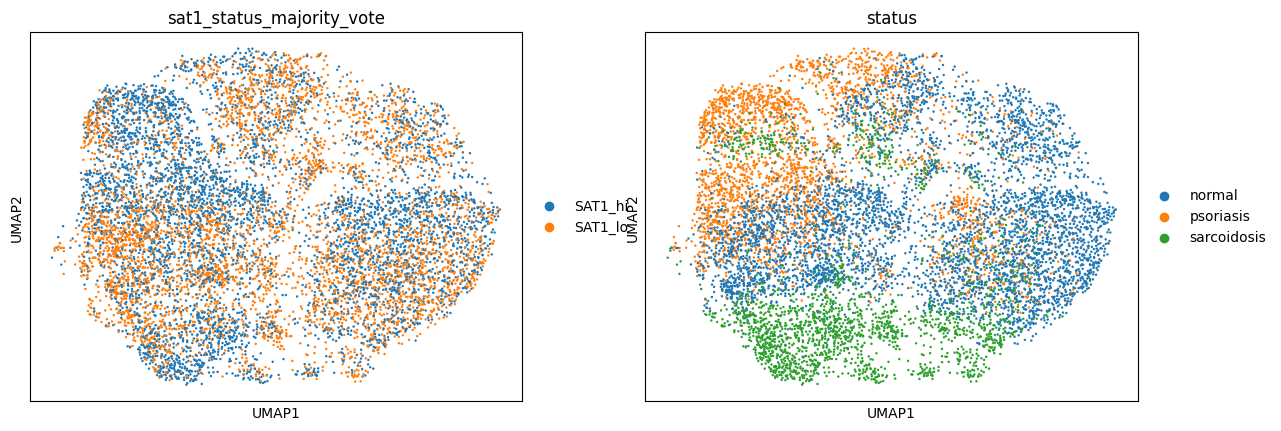

raw_p0.01


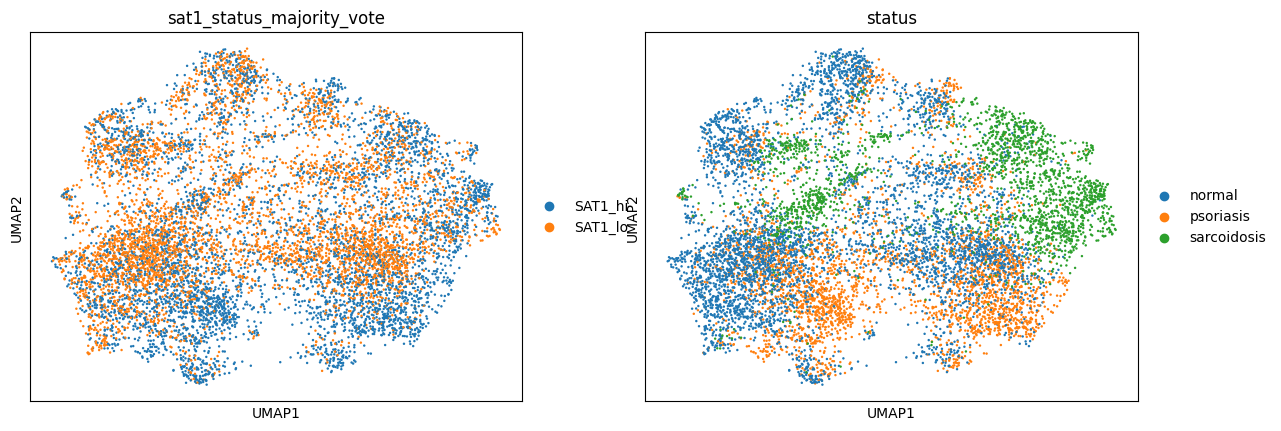

raw_p0.005


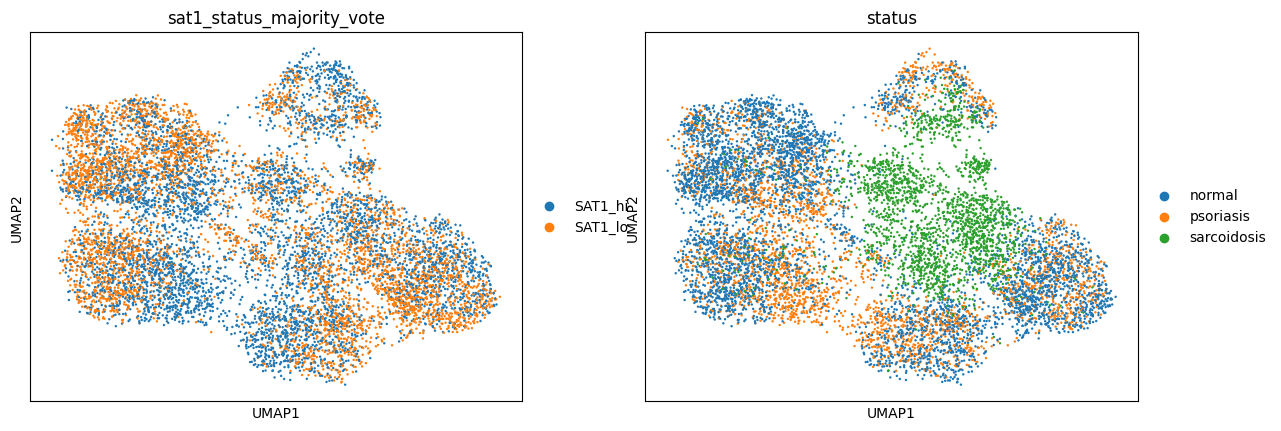

raw_p0.001


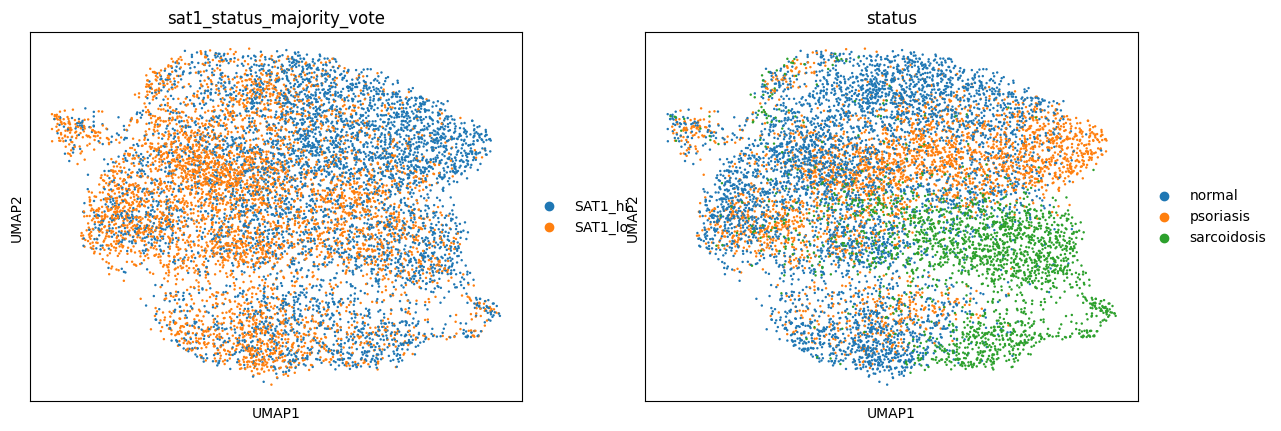

recombat_p0.05


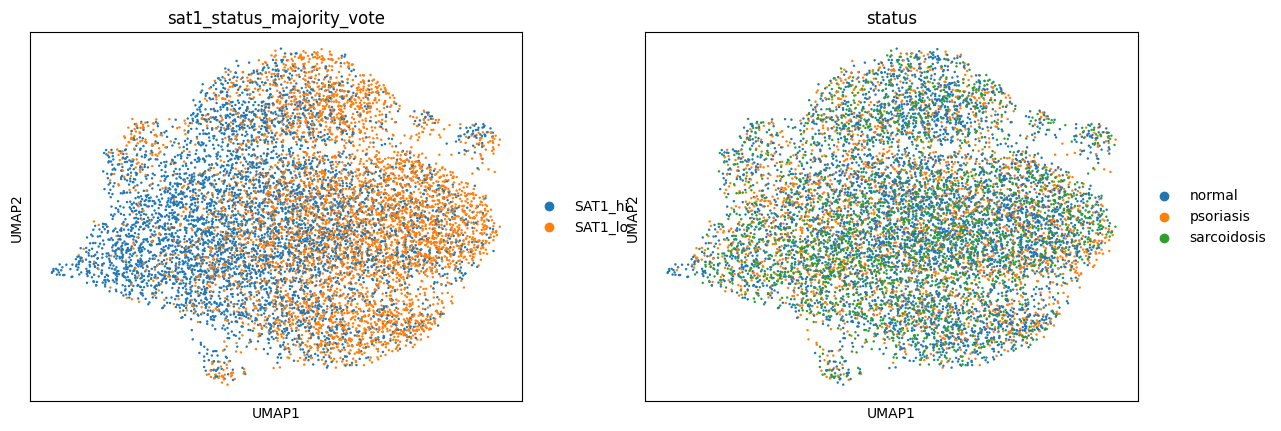

recombat_p0.01


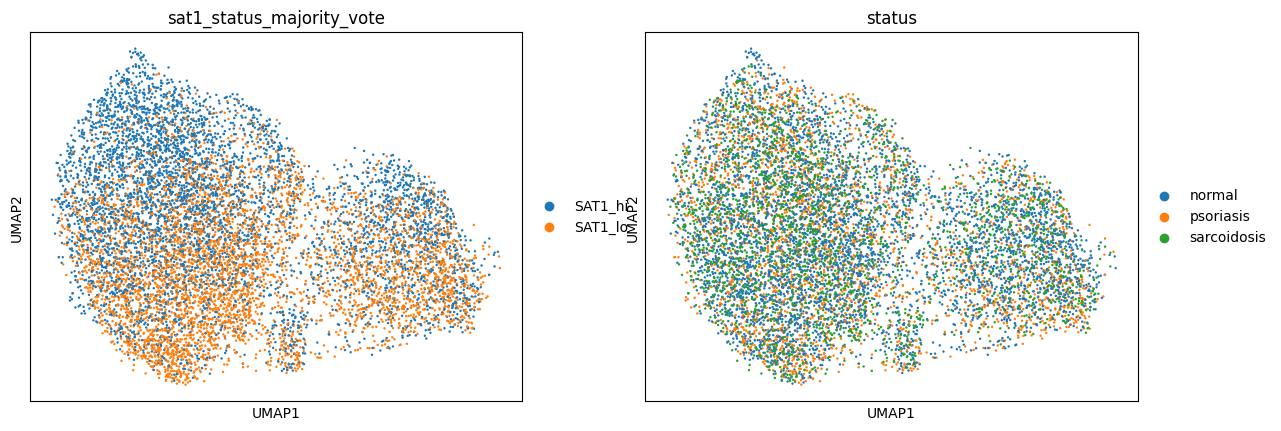

recombat_p0.005


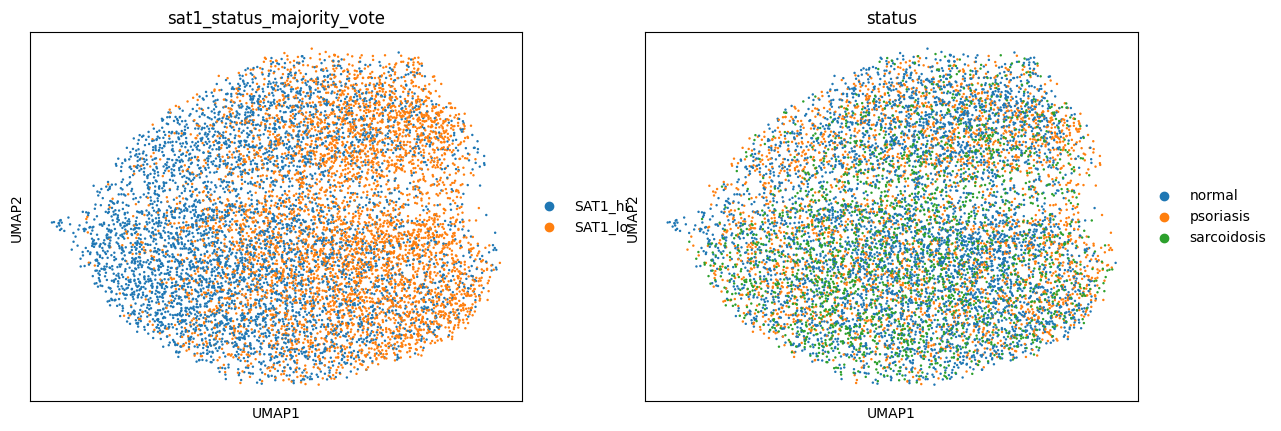

recombat_p0.001


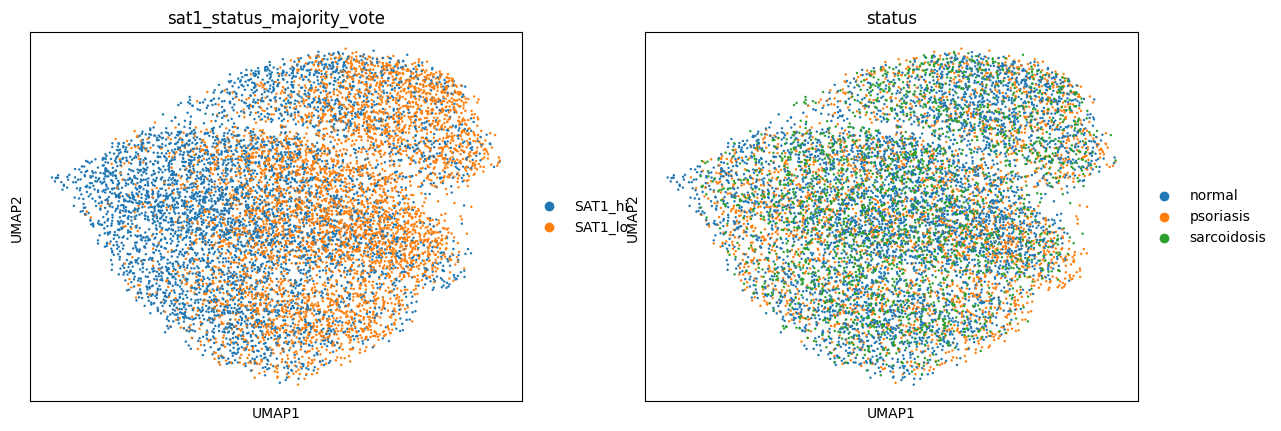

raw_disease_p0.05


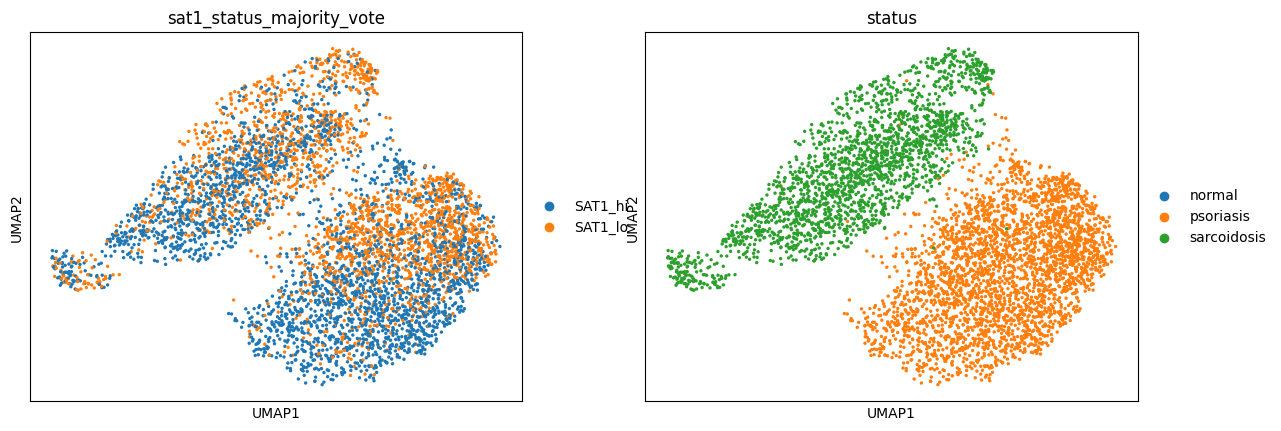

raw_disease_p0.01


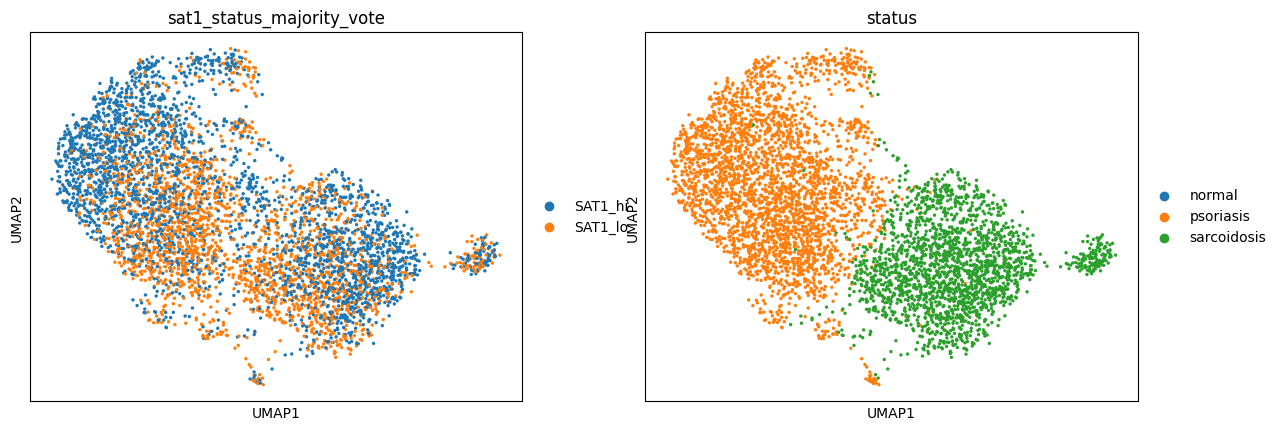

raw_disease_p0.005


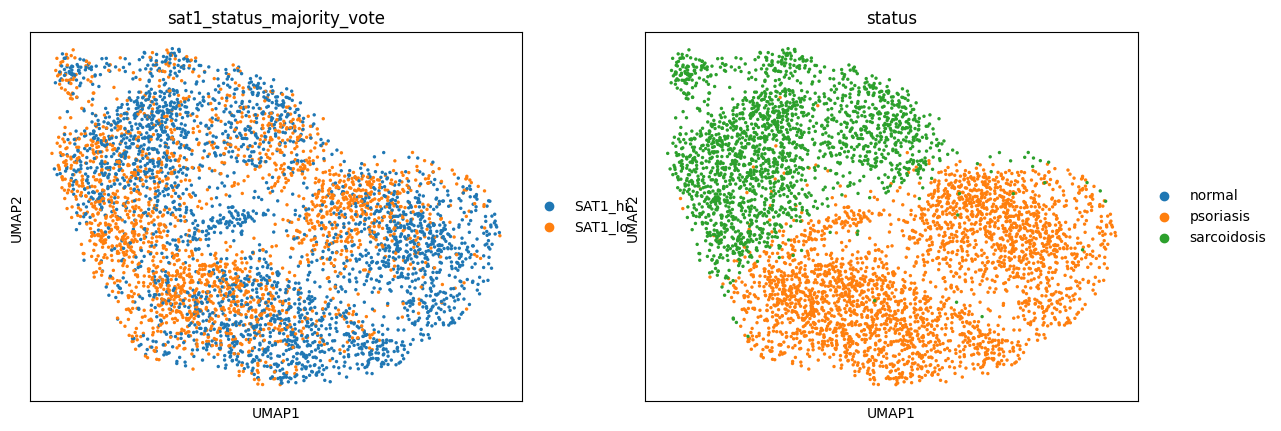

raw_disease_p0.001


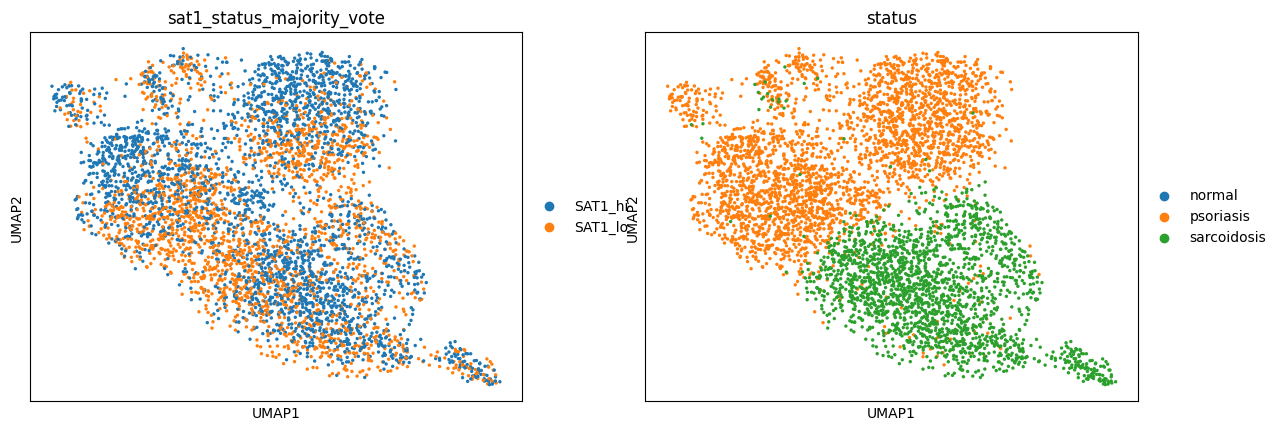

recombat_disease_p0.05


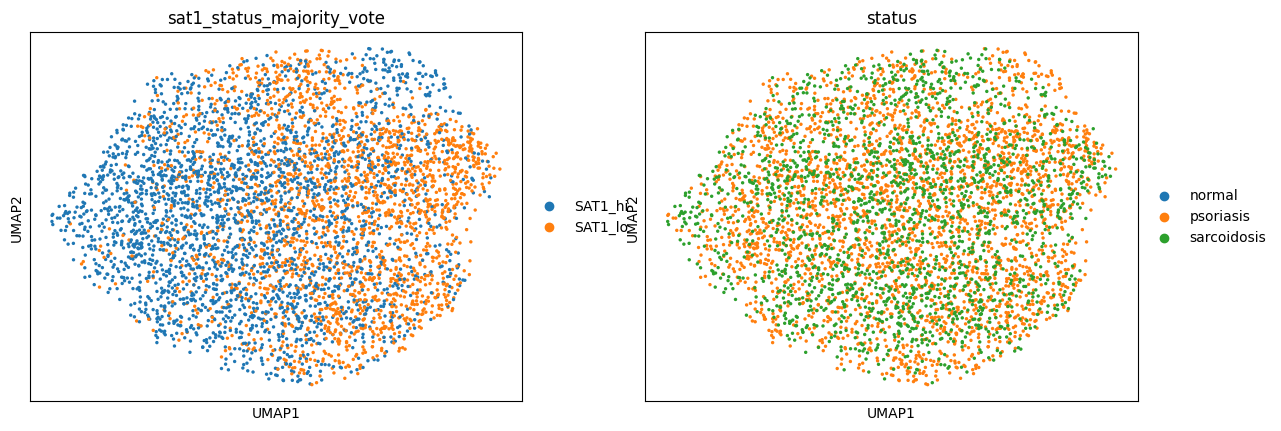

recombat_disease_p0.01


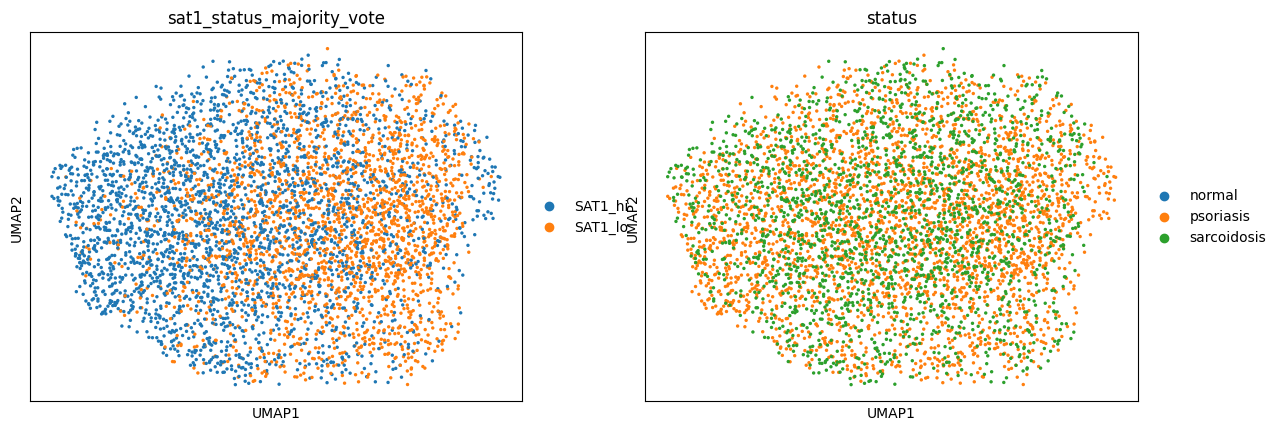

recombat_disease_p0.005


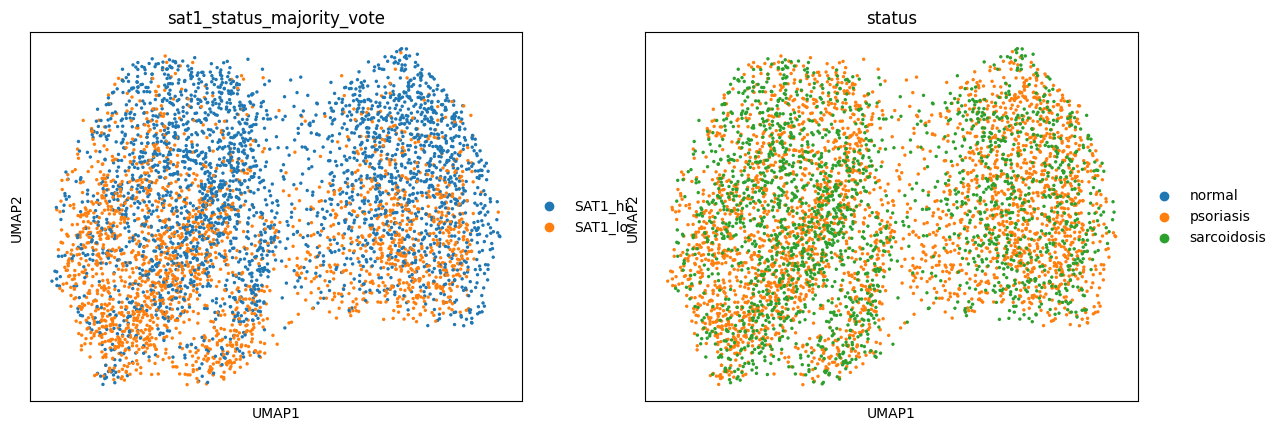

recombat_disease_p0.001


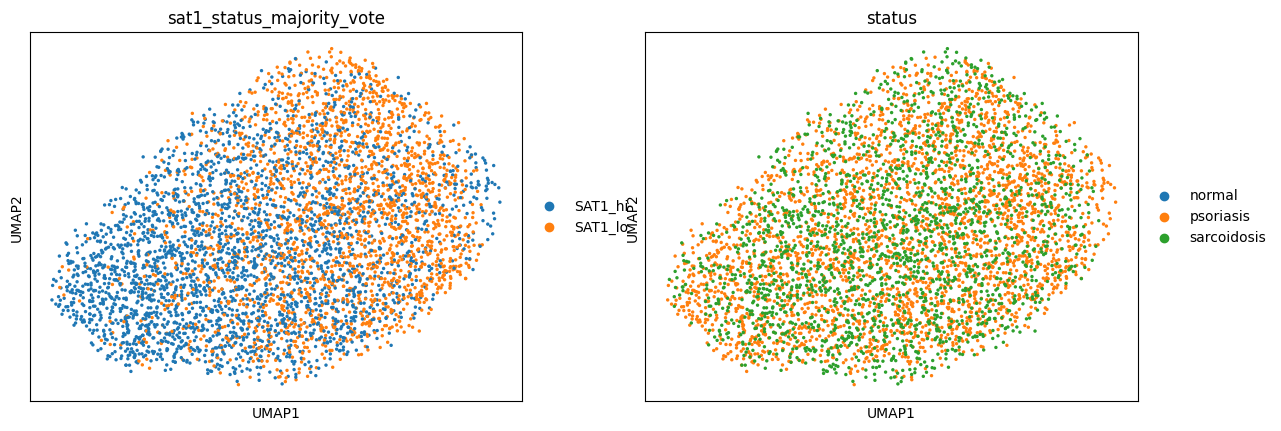

In [30]:
for k, adata in adatas.items():
    print(k)
    sc.pl.umap(
        adata, 
        color = [
            'sat1_status_majority_vote',
            'status'
        ]
    )